# HyperSHAP: Example for ablation explanations

In this example, we consider the scenario where we want to explain the values of a specific configuration and how its individual setting affects performance contrasting with a baseline configuration.

## Mockup setup of environment
To this end, we first setup some basic environment, which is assumed to be already existing when working with HyperSHAP. We will setup a configuration space, a baseline configuration and a configuration of interest we would like to explain in the subsequent example.

In [1]:
import math

from ConfigSpace import Configuration, ConfigurationSpace

# Configuration space with a float, integer, and categorical hyperparameter
cs = ConfigurationSpace(
    name="myspace",
    space={
        "a": (0.1, 1.5),  # UniformFloat
        "b": (2, 10),  # UniformInt
        "c": ["X", "Y"],  # Categorical
    },
)


# Some evaluation function that assesses the performance of some configuration
def eval_fun(config: Configuration) -> float:
    if config["c"] == "X":
        return math.sin(config["a"]) + config["b"]
    elif config["c"] == "Y":
        return math.cos(config["a"] * config["b"]) + 1.5
    else:
        return 0


# some helper function for conducting some random search HPO
def random_search(config_space, fun, n) -> Configuration:
    configs = config_space.sample_configuration(n)
    best_config = None
    best_val = None
    for config in configs:
        val = fun(config)
        if best_config is None or val > best_val:
            best_config = config
            best_val = val
    return best_config


cs.seed(42)  # set some random seed for reproducibility

# sample some configuration as a baseline
baseline_config = cs.sample_configuration()
# get some "optimized configuration"
config_of_interest = random_search(cs, eval_fun, 1000)

print("Baseline", baseline_config, "\nValue", eval_fun(baseline_config))
print("")
print("Config of interest", config_of_interest, "\nValue", eval_fun(config_of_interest))

Baseline Configuration(values={
  'a': 0.6243561663863,
  'b': 4,
  'c': np.str_('Y'),
}) 
Value 0.7004003054122951

Config of interest Configuration(values={
  'a': 1.45774946311,
  'b': 10,
  'c': np.str_('X'),
}) 
Value 10.99361700532433


## HyperSHAP Instantiation with Configuration Space and Surrogate Model

Now it is time to instantiate HyperSHAP. For this, we need to define an explanation task that consists of a configuration space and a surrogate model for predicting the performance of a configuration. `ExplanationTask` comes with a couple of static convenience functions that facilitate the transition from the above configuration space and eval function to an explanation task. For simply building a surrogate model from the specified evaluation function, we can simply call the `from_function()` method and give the resulting explanation task to HyperSHAP.

In [2]:
from hypershap.hypershap import HyperSHAP
from hypershap.task import ExplanationTask

explanation_task = ExplanationTask.from_function(config_space=cs, function=eval_fun)
hypershap = HyperSHAP(explanation_task=explanation_task)

/Users/wever/PycharmProjects/HyperSHAP-automl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# HyperSHAP Ablation

In [3]:
iv = hypershap.ablation(config_of_interest=config_of_interest, baseline_config=baseline_config)
print(iv)

InteractionValues(
    index=FSII, max_order=2, min_order=0, estimated=False, estimation_budget=None,
    n_players=3, baseline_value=0.0,
    Top 10 interactions:
        (1, 2): 4.9573078078165596
        (2,): 4.146630892840449
        (1,): 1.0484535720156407
        (0, 2): 2.7297799146286056e-11
        (0, 1): 2.7295134611026955e-11
        (): 0.0
        (0,): -4.548836866730854e-11
)


## Plot Shapley Interactions Graph

Now that we have determined the interaction values of the ablation game, let us look into some visualizations of the scenario above.

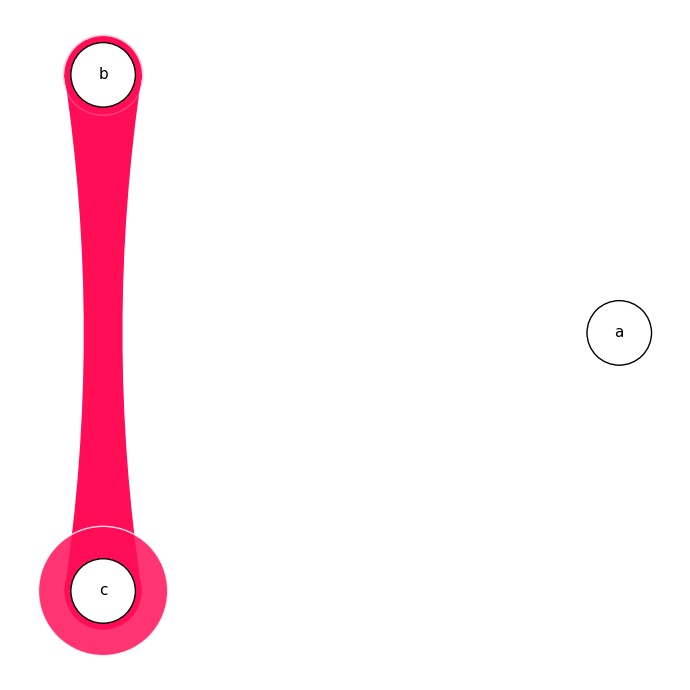

In [4]:
hypershap.plot_si_graph()